# <img src="./assets/course-icon.png" style="height:50px;display:inline"> Deep Learning
---

create by Arwin Yu

## Tutorial 02 - Convolutional Neural Networks & Visual Tasks
---
<center><img src="./assets/tut_conv_cnn.png" style="height:200px"></center>

<a href="https://mc.ai/how-does-convolutional-neural-network-work/">Image Source</a>

### <img src="https://img.icons8.com/bubbles/50/000000/checklist.png" style="height:50px;display:inline"> Agenda
---

* 2D卷积（2D Convolution）
* 基于卷积的特征提取（Convlution as Feature Extractors）
* 卷积神经网络（Convolutional Neural Networks）
    * 通道概念
    * 局部相关性
    * 平移不变性
    * 池化层
    * 打平操作
    * 全连接层
* 卷积模型的层级结构与特征可视化（Hierarchical structure and feature visualization）
* 卷积模型的感受野（Receptive field of convolutional model）
* 正则化（Regularzation）
    * 数据增强
    * 丢弃法
    * 正则项
* 示例项目（CIFAR-10 Classification with PyTorch）
* 可视化卷积核（Visualizing CNN kernels）
* 卷积模型的常见问题（The Problem with CNNs）
* 卷积模型的场景应用（The Application of CNNs）

In [1]:
# imports for the tutorial
import numpy as np
import matplotlib.pyplot as plt
import time
import os

# pytorch
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms

## <img src="https://img.icons8.com/dusk/64/000000/layers.png" style="height:50px;display:inline"> 2D Convolution
---

2D卷积的操作如下所示 



<center><img src="./assets/tut_conv_num_ex.PNG" style="height:200px"></center>

<center><img src="./assets/tut_conv_anim.gif" style="height:400px"></center>

## <img src="https://img.icons8.com/color/96/000000/tweezers.png" style="height:50px;display:inline"> Convolution as Feature Extractors for Classification
---

* 卷积操作可以从图像中进行特征的提取，不同的卷积核会尝试提取不同的特征。
* 例如， gradient/derivative filter 可以帮助我们检测**边缘**。

<center><img src="./assets/tut_conv_derv_filt.PNG" style="height:150px"></center>

* 根据卷积操作找到的特征，神经网络层或其他分类器可以根据这些特征进一步判断它们的所属类别。
 
 <center><img src="./assets/tut_conv_image_class.jpg" style="height:150px"></center>
    * <a href="https://www.mathworks.com/solutions/deep-learning/convolutional-neural-network.html">Image Source</a>

什么是特征？考虑以下说明性示例 - 对 *猫* 和 *狗* 进行分类。

我们如何区分猫和狗？我们可以看看尾巴的长度、爪子的形状、毛发的图案等...

人类通常只需查看样本即可分辨出这些。但计算机看到了什么？

在分类任务中，我们需要 *好的特征* 来学习从样本映射到标签的函数。

**原始像素** 通常不是足够有表现力的特征！这是因为原始像素无法捕捉图像中的 *空间关系*。

使用卷积，我们可以捕捉 **空间结构**（例如，尾巴形状的像素）。

卷积的核心本质：**对局部区间的信息提取。**

### <img src="https://img.icons8.com/dusk/64/000000/s.png" style="height:50px;display:inline"> The Softmax Function
---
* 假设我们设计了一个分类架构，分类模型中最后一个全连接层的输出是一个长度为 $\text{num-classes}$ 的向量，它正好是我们拥有的类数（例如，在 MNIST 或 CIFAR-10 中，我们有 10 个类，因此输出维度为 10）！
* 在输出向量中，我们希望条目 $i$ 是输入来自类 $i$ 的概率。
* 但我们如何强制这个向量输出概率而不仅仅是一些数字？
* 我们将使用**Softmax**函数将其标准化为概率。

* The Softmax function is defined as: $$ Softmax(x_i) = \frac{e^{x_i}}{\sum_{j=1}^M e^{x_j}}, i \in [1,...,M], x \in \mathcal{R}^M  $$
* This forces the output vector to sum to 1, just like probabilities.

<center><img src="./assets/tut_conv_softmax.PNG" style="height:150px"></center>

### <img src="https://img.icons8.com/plasticine/100/000000/unicorn.png"  style="height:50px;display:inline"> Making Predictions
---
* 现在，我们有一个概率输出向量，那么我们如何预测输入图像的标签呢？
* 很简单！只需取 $argmax$： $$ \hat{y} = Softmax(NN(x)) $$ $$ c_{pred} = argmax_i (\hat{y}) $$

### <img src="https://img.icons8.com/dusk/64/000000/bearish.png" style="height:50px;display:inline"> Loss Function - Cross Entropy 
---
* 为了以端到端的方式训练模型，我们需要定义一个损失函数，我们可以使用优化技术将其最小化。
* 假设我们的模型输出（经过 softmax 之后）为 $\hat{y}$，而真实标签（给我们的真实类别）为 $y$。

<center><img src="./assets/tut_conv_x_y.PNG" style="height:150px"></center>

交叉熵损失函数在分类问题中的应用可以通过公式来更好地理解。对于一个多分类问题，交叉熵损失函数通常定义为:
$$
L=-\sum_{i=1}^N \sum_{c=1}^C y_{i, c} \log \left(\hat{y}_{i, c}\right)
$$

其中:
- $N$ 是样本数量。
- $C$ 是类别数量。
- $y_{i, c}$ 是样本 $i$ 的真实标签，如果样本 $i$ 属于类别 $c$ ，则 $y_{i, c}=1$ ，否则 $y_{i, c}=0$ 。
- $\hat{y}_{i, c}$ 是模型预测样本 $i$ 属于类别 $c$ 的概率。

对于每一个样本 $i$, 真实标签 $y_{i, c}$ 只有一个值为 1 (即正确类别)，其他类别的值都为 0 。假设样本 $i$ 属于类别 $c$ ，则 $y_{i, c}=1$ ，其他类别 $y_{i, j}=0$ (其中 $j \neq c$ )。

因此，对于样本 $i$ 的交叉摘损失主要由 $\log \left(\hat{y}_{i, c}\right)$ 决定，因为其他项的 $y_{i, j} \log \left(\hat{y}_{i, j}\right)$ 都为 0 。即:
$$
L_i=-y_{i, c} \log \left(\hat{y}_{i, c}\right)=-\log \left(\hat{y}_{i, c}\right)
$$

当预测概率 $\hat{y}_{i, c}$ 越接近真实标签 $y_{i, c}$ 时，即 $\hat{y}_{i, c}$ 越接近 1 时， $\log \left(\hat{y}_{i, c}\right)$ 越接近 0 ，因为 $\log (1)=0$ 。

## <img src="https://img.icons8.com/bubbles/50/000000/mind-map.png" style="height:50px;display:inline"> Convolutional Neural Networks (CNNs)

下面，我们现在将介绍卷积神经网络（CNN）的基本构成要素以及实现对图像数据进行有效学习的思想。

### Feature Mapping and Multiple Channels
---

<center><img src="./assets/cnnchannel.png" style="height:350px"></center>

在下面动图中，卷积核的数量为8个，每个卷积核的形状为8x3x3，其中8为卷积核特征通道的数量，这与输入数据的特征通道数量是相等的。卷积核在计算过程中的填充为1，步长为2，每个卷积核都可计算得到一张特征图，8个卷积核可计算得到8张，因此最后输出结果的通道数量也为8.

<center><img src="./assets/cnngif.gif" style="height:400px"></center>

#### <img src="https://img.icons8.com/?size=100&id=91CnU00i6HLv&format=png&color=000000" style="height:50px;display:inline"> 卷积处理图像数据的有效性如何解释？
---





<center><img src="./assets/conv.png" style="height:400px"></center>

* 参数少，易训练
* 局部相关性
* 平移不变性（参数共享）

**卷积如何进行特征提取？**

不同的卷积核可以从图像中提取不同的特征。因为当提取的特征太少，是没有办法完成图像识别这个任务的。一个简单的例子：我们不能凭借眼睛这一种特征来识别猫和狗这两个类别，往往需要根据眼睛、嘴巴、外形、毛发、耳朵等等多种特征才能对猫和狗做正确的识别。

<center><img src="./assets/cnnf.png" style="height:250px"></center>


### Pooling
---
* 池化可以看出特殊的卷积操作，唯一的不同之处在于其不是应用可以训练的权重，而是在其窗口的中应用某种类型的统计函数。
* 最常见的池化类型称为**最大池化**，它将 $max()$ 函数应用于窗口的内容。



<center><img src="./assets/pool.png" style="height:400px"></center>

<a href="https://medium.com/@duanenielsen/deep-learning-cage-match-max-pooling-vs-convolutions-e42581387cb9">Image Source </a>

#### <img src="https://img.icons8.com/?size=100&id=91CnU00i6HLv&format=png&color=000000" style="height:50px;display:inline"> 池化有没有可学习参数？
---


CNN 中的池化一般用于下采样操作。如下所示，5 x 5 输入减小为 3 x 3 输出。 

<center><img src="./assets/tut_xiv_max_pool.jpg" style="height:200px" /></center>

在上面的池化图中，在 5 x 5 输入中添加了额外的列和行 - 这使得池化空间的有效大小等于 6 x 6。这是为了确保 2 x 2 池化窗口能够以 [2, 2] 的步幅正确运行 - *填充*。虽然我们通常用零填充，但也可以用其他值填充。

* 另一方面，最大池化可以进行特征的汇聚。


* 其他池化操作:
<center><img src="./assets/tut_conv_other_pool.PNG" style="height:150px"></center>

### The FC Layer
---
* 全连接层可以被看作是将一个标准分类器附加到网络的信息丰富的输出上，以“解释”结果并最终产生分类结果。换句话说，卷积层的输出成为分类器的新“输入特征”。
* 为了将这个全连接层附加到网络上，需要将卷积神经网络的输出维度进行展平。

* 注意：有些网络（例如，全卷积网络，FCN）根本不使用全连接层！
比如，你可以设计卷积核，使得最终输出是形状为 [num_classes, 1, 1]（num_channels 个通道，高度为1，宽度为1）的张量，并使用它进行分类。这在执行图像分割或生成的网络中也非常有用，因为这些网络的输出是像素。

<center><img src="./assets/cnng.png" style="height:700px"></center>

### Calculating the Convolutional Layer Output Shape
---
我们定义了*卷积层* 的以下参数：
* $W_{in}$ - 输入的宽度
* $F$ - 卷积核大小
* $P$ - 填充
* $S$ - 步幅

输出特征图的大小:
$$W_{out} = \frac{W_{in} - F + 2P}{S} + 1$$

考虑大小为 $28\times 28$ 的输入图像、卷积核大小为 $5\times 5$、填充为 2、步幅为 1
$$W_{1, out} = \frac{28 - 5 + 2*2}{1} + 1 = 28 \rightarrow MaxPooling(2x2) \rightarrow 28 / 2 = 14$$

<center><img src="./assets/tut_conv_op.png" style="height:300px"></center>

<a href="https://towardsdatascience.com/a-comprehensive-introduction-to-different-types-of-convolutions-in-deep-learning-669281e58215">Image Source</a>

<center><img src="./assets/conv_anim.gif" style="height:300px"></center>

Animation by <a href="https://medium.com/@nadeemhqazi/a-brief-introduction-to-convolution-neural-network-4821215aa591">Nadeem Qazi</a>.

### <img src="https://img.icons8.com/color/96/000000/layers.png" style="height:50px;display:inline"> Low Level (Shallow) and High Level (Deep) Features
---
* 为了解释CNN的原理，ZFNet等相关工作在网络的不同层级观察特征（卷积核的输出）。
* **低层** - 浅层特征，包括线条、角、边缘、颜色等。
* **中层** - 中间层特征，通常是物体的一部分。
* **高层** - 深层特征，更大视角我物体，甚至是整个物体。

<center><img src="./assets/tut_conv_low_high_level_feat.png" style="height:350px"></center>

<a href="https://medium.com/analytics-vidhya/the-world-through-the-eyes-of-cnn-5a52c034dbeb">Image Source</a>

这其实与CNN的感受野相关：感受野（Receptive Field）是指卷积神经网络中某一神经元在输入图像上感受到的区域大小。换句话说，感受野描述了神经元对输入图像的哪些部分产生响应。

<center><img src="./assets/ganshouye.png" style="height:350px"></center>

### Non-Linear Activations
---
* 激活函数在卷积神经网络（CNN）中用于引入非线性，使模型能够学习和表示复杂的模式和特征。
* 它将卷积层的线性输出转换为非线性输出，从而增强模型的表达能力和分类性能。
* 常见的激活函数如ReLU、Sigmoid和Tanh在不同层次和任务中发挥关键作用，影响CNN的整体性能和训练效果。

<center><img src="./assets/tut_conv_activation.PNG"></center>

### <img src="https://img.icons8.com/officel/80/000000/rope.png" style="height:50px;display:inline"> Regularization - Preventing Overfitting
---
在卷积神经网络（CNN）中，**过拟合**是指模型在训练数据上表现优异，但在新数据上表现不佳的现象。这通常是因为模型过于复杂，能够记住训练数据中的噪声和细节，而不是学习到真正的模式和特征。

为了解决过拟合问题，常用的方法有数据增强和正则化：

数据增强：通过对训练数据进行各种随机变换（如旋转、缩放、平移等）来生成更多的训练样本，从而增加数据的多样性，帮助模型更好地泛化。

正则化：通过引入正则项（如L2正则化）来限制模型的复杂度，防止权重过大，或者使用Dropout技术随机丢弃一些神经元，以减少模型对特定路径的依赖。
 

* 过拟合的反义词是**欠拟合**。这种情况可能出于多种原因：如果模型不够强大、过度正则化，或者只是训练时间不够长。这意味着网络尚未学习训练数据中的相关模式。

* 正则化通常以对参数施加约束的形式出现，或者在神经网络的情况下，对层的权重施加约束。 
* 常见的正则化有 $L_2、L_1$ 正则化： $$ \text{New Loss}_{L_2} = \text{Original Loss} + \lambda \mid \mid w \mid \mid^2$$
* 对于深度神经网络（和 CNN），一种常见的正则化技术是 **Dropout**。

#### Dropout Regularization
----
* 首次出现在 <a href="http://jmlr.org/papers/v15/srivastava14a.html">Dropout: A Simple Way to Prevent Neural Networks from Overfitting</a>, 2014.
* Dropout 是一种正则化方法，**近似于并行训练大量具有不同架构的神经网络**。
* 在训练期间，一些层输出（即神经元）被随机忽略或以某个概率 $p$“丢弃”。
* Dropout 会使训练过程变得嘈杂，迫使层内的节点概率地承担更多或更少的输入责任。
* Dropout 仅在**训练**期间激活**（`model.train()`）。在测试时，它会关闭（`model.eval()`）。
* Dropout 从某种程度来说，有点“集成学习”的思想

阅读更多 - <a href="https://machinelearningmastery.com/dropout-for-regularizing-deep-neural-networks/">深度神经网络正则化 Dropout 的简单介绍</a>

<center><img src="./assets/tut_conv_dropout.png" style="height:250px"></center>

<a href="https://www.oreilly.com/library/view/tensorflow-for-deep/9781491980446/ch04.html">Image Source</a>

### <img src="https://img.icons8.com/dusk/64/000000/variation.png" style="height:50px;display:inline"> Data Augmentation
---
* 数据增强是一种常用技术，可以改善结果并避免过度拟合，帮助网络更好地泛化。
* **当样本数量有限时，我们如何获得更多数据？**我们可以进行数据增强。
* 数据增强通过添加原始样本的变体来丰富数据集。 

* Popular augmentation techniques:
    * **翻转** - 水平和/或垂直翻转图像。
    * **旋转** - 将图像旋转一定角度。这可能会改变图像的大小，因此，裁剪或填充是常见的解决方法。
    * **缩放** - 图像可以向外或向内缩放。这也可能会改变图像的大小，因此通常会进行调整大小（也包括拉伸）。
    * **裁剪** - 从原始图像中随机抽取一部分。然后将此部分调整为原始图像大小。这称为随机裁剪。
    * **平移** - 沿 X 或 Y 方向（或两者）移动图像。这会迫使神经网络到处查看。
    * **噪声** - 过度拟合通常发生在网络尝试学习可能没用的高频特征（经常出现的模式）时。高斯噪声的均值为零，基本上在所有频率中都有数据点，从而有效地扭曲了高频特征。这也意味着较低频率的成分（通常是您想要的数据）也会失真，但您的神经网络可以学会忽略这一点。添加适量的噪音可以增强学习能力（例如，添加盐和胡椒）。
    
Read More - <a href="https://nanonets.com/blog/data-augmentation-how-to-use-deep-learning-when-you-have-limited-data-part-2/">Data Augmentation | How to use Deep Learning when you have Limited Data</a>

<center><img src="./assets/tut_conv_augment.png" style="height:300px"></center>

<a href="https://towardsdatascience.com/machinex-image-data-augmentation-using-keras-b459ef87cd22">Image Source</a>

### <img src="./assets/kornia_logo.svg" style="height:50px;display:inline"> Kornia: Differentiable GPU-Accelerated Augmentations
---
* <a href="https://kornia.github.io/">Kornia</a> 是一个可微分的库，它允许在GPU上直接进行数据增强以及应用其他图像和几何操作/变换，并且可以通过这些操作进行反向传播！ 
    * 这是 torchvision 实现的数据增强所无法做到的，通常需要将图像张量发送回CPU。
* See <a href="https://kornia.github.io/tutorials/">Jupyter Notebook Tutorials using Kornia</a>.

<center><img src="./assets/tut_conv_kornia_2.gif" style="height:300px"></center>

<table class="docutils align-default" id="id1">
<caption><span class="caption-text">这是在 <a class="reference external" href="https://colab.research.google.com/drive/1b-HpK4EsZR8uolztgH4roNBLaDwcMULx?usp=sharing">Google Colab</a>
K80 GPU 上使用不同库和批次大小执行的基准测试。此基准测试显示了
Kornia 数据增强带来的强大 GPU 增强速度加速。图像大小固定为 224x224，
单位为毫秒 (ms)。</span></caption>
<colgroup>
<col style="width: 27%">
<col style="width: 15%">
<col style="width: 15%">
<col style="width: 15%">
<col style="width: 15%">
<col style="width: 15%">
</colgroup>
<thead>
<tr class="row-odd"><th class="head"><p>Libraries</p></th>
<th class="head"><p>TorchVision</p></th>
<th class="head"><p>Albumentations</p></th>
<th class="head" colspan="3"><p>Kornia (GPU)</p></th>
</tr>
<tr class="row-even"><th class="head"><p>Batch Size</p></th>
<th class="head"><p>1</p></th>
<th class="head"><p>1</p></th>
<th class="head"><p>1</p></th>
<th class="head"><p>32</p></th>
<th class="head"><p>128</p></th>
</tr>
</thead>
<tbody>
<tr class="row-odd"><td><p>RandomPerspective</p></td>
<td><p>4.88±1.82</p></td>
<td><p>4.68±3.60</p></td>
<td><p>4.74±2.84</p></td>
<td><p>0.37±2.67</p></td>
<td><p>0.20±27.00</p></td>
</tr>
<tr class="row-even"><td><p>ColorJiggle</p></td>
<td><p>4.40±2.88</p></td>
<td><p>3.58±3.66</p></td>
<td><p>4.14±3.85</p></td>
<td><p>0.90±24.68</p></td>
<td><p>0.83±12.96</p></td>
</tr>
<tr class="row-odd"><td><p>RandomAffine</p></td>
<td><p>3.12±5.80</p></td>
<td><p>2.43±7.11</p></td>
<td><p>3.01±7.80</p></td>
<td><p>0.30±4.39</p></td>
<td><p>0.18±6.30</p></td>
</tr>
<tr class="row-even"><td><p>RandomVerticalFlip</p></td>
<td><p>0.32±0.08</p></td>
<td><p>0.34±0.16</p></td>
<td><p>0.35±0.82</p></td>
<td><p>0.02±0.13</p></td>
<td><p>0.01±0.35</p></td>
</tr>
<tr class="row-odd"><td><p>RandomHorizontalFlip</p></td>
<td><p>0.32±0.08</p></td>
<td><p>0.34±0.18</p></td>
<td><p>0.31±0.59</p></td>
<td><p>0.01±0.26</p></td>
<td><p>0.01±0.37</p></td>
</tr>
<tr class="row-even"><td><p>RandomRotate</p></td>
<td><p>1.82±4.70</p></td>
<td><p>1.59±4.33</p></td>
<td><p>1.58±4.44</p></td>
<td><p>0.25±2.09</p></td>
<td><p>0.17±5.69</p></td>
</tr>
<tr class="row-odd"><td><p>RandomCrop</p></td>
<td><p>4.09±3.41</p></td>
<td><p>4.03±4.94</p></td>
<td><p>3.84±3.07</p></td>
<td><p>0.16±1.17</p></td>
<td><p>0.08±9.42</p></td>
</tr>
<tr class="row-even"><td><p>RandomErasing</p></td>
<td><p>2.31±1.47</p></td>
<td><p>1.89±1.08</p></td>
<td><p>2.32±3.31</p></td>
<td><p>0.44±2.82</p></td>
<td><p>0.57±9.74</p></td>
</tr>
<tr class="row-odd"><td><p>RandomGrayscale</p></td>
<td><p>0.41±0.18</p></td>
<td><p>0.43±0.60</p></td>
<td><p>0.45±1.20</p></td>
<td><p>0.03±0.11</p></td>
<td><p>0.03±7.10</p></td>
</tr>
<tr class="row-even"><td><p>RandomResizedCrop</p></td>
<td><p>4.23±2.86</p></td>
<td><p>3.80±3.61</p></td>
<td><p>4.07±2.67</p></td>
<td><p>0.23±5.27</p></td>
<td><p>0.13±8.04</p></td>
</tr>
<tr class="row-odd"><td><p>RandomCenterCrop</p></td>
<td><p>2.93±1.29</p></td>
<td><p>2.81±1.38</p></td>
<td><p>2.88±2.34</p></td>
<td><p>0.13±2.20</p></td>
<td><p>0.07±9.41</p></td>
</tr>
</tbody>
</table>

### <img src="https://img.icons8.com/dusk/64/null/downloads.png" style="height:50px;display:inline"> Torchvision Datasets
---
* Torchvision 在 `torchvision.datasets` 模块中提供了许多内置数据集，以及用于构建您自己的数据集的实用程序类。
* <a href="https://pytorch.org/vision/stable/datasets.html#datasets">Torchvision 数据集</a>
* 示例：`torchvision.datasets.CelebA`、`torchvision.datasets.Flowers102`、`torchvision.datasets.ImageNet`。
* 如果您想用自己的图像创建数据集，则可以使用<a href="https://pytorch.org/vision/stable/generated/torchvision.datasets.ImageFolder.html#torchvision.datasets.ImageFolder">`torchvision.datasets.ImageFolder`</a> 和 <a href="https://pytorch.org/vision/stable/generated/torchvision.datasets.VisionDataset.html#torchvision.datasets.VisionDataset">`torchvision.datasets.VisionDataset`</a>，或者您可以自己实现 `Dataset` 类。以下是一个基于PyTorch实现自定义 Dataset 类的示例代码，包括 __init__, __len__, 和 __getitem__ 方法：

In [2]:
import torch
from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image
import os

class CustomDataset(Dataset):
    def __init__(self, image_dir, transform=None):
        """
        Args:
            image_dir (str): Path to the directory with images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.image_dir = image_dir
        self.image_filenames = os.listdir(image_dir)
        self.transform = transform

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.image_dir, self.image_filenames[idx])
        image = Image.open(img_name).convert('RGB')
        
        if self.transform:
            image = self.transform(image)

        return image


## <img src="https://img.icons8.com/clouds/100/000000/dog.png" style="height:50px;display:inline"> The CIFAR-10 Dataset
---

* CIFAR-10 数据集包含 10 个类别的 60000 张 32x32 彩色图像，每个类别有 6000 张图像。有 50000 张训练图像和 10000 张测试图像。
* 还有 CIFAR-100，有 100 个类别。

* <a href="https://www.cs.toronto.edu/~kriz/cifar.html">Official Site</a>

<center><img src="./assets/tut_conv_cifar10.PNG" style="height:300px"></center>


In [3]:
# define pre-processing steps on the images
# also called "data augementation" (only done for the train set)
# to use 'kornia' instead of torchvision, see example after

transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4), # input is PIL image
    transforms.RandomHorizontalFlip(), # input is PIL image, can also set the probability parameter 'p'
    transforms.ToTensor(),  # uint8 values in [0, 255] -> float tensor with values [0, 1] 
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),  # [mu, sigma] standartization RGB values
    # notice the order: first iamges transformation on PIL, then ToTensor, then normalization.
])

# how are the standartization params (mu, sigma) calculated? 
# iterate over the entire train set to get the R, G, and B values of the all images, compute their mean and std

# Normalize the test set same as training set without augmentation
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

# test-time augementations (TTA): for a more robust prediciton, we can apply N augs on each input and get N scores, take the average of the scores.

# load dataset
classes = ('plane', 'car', 'bird', 'cat', 'deer', 
           'dog', 'frog', 'horse', 'ship', 'truck')

trainset = torchvision.datasets.CIFAR10(
    root='./datasets', train=True, download=True, transform=transform_train)

testset = torchvision.datasets.CIFAR10(
    root='./datasets', train=False, download=True, transform=transform_test)

Files already downloaded and verified
Files already downloaded and verified


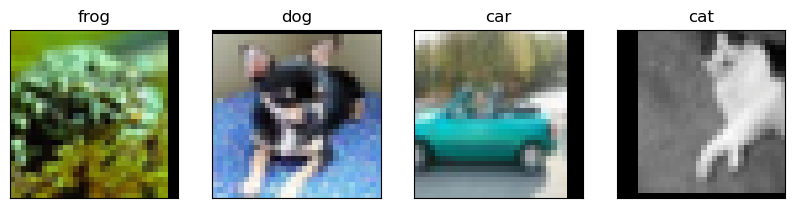

In [4]:
# let's see some of the images
def convert_to_imshow_format(image): 
    # first convert back to [0,1] range
    mean = torch.tensor([0.4914, 0.4822, 0.4465])
    std = torch.tensor([0.2023, 0.1994, 0.2010])
    image = image * std[:, None, None] + mean[:, None, None]  # [:, None, None] changes the shape from [N] to [N, 1, 1]
    image = image.clamp(0, 1).numpy()
    # convert from CHW to HWC
    # from 3x32x32 to 32x32x3
    return image.transpose(1, 2, 0)

trainloader = torch.utils.data.DataLoader(trainset, 
                                          batch_size=4,
                                          shuffle=True)
dataiter = iter(trainloader)
images, labels = next(dataiter)

fig, axes = plt.subplots(1, len(images), figsize=(10, 2.5))
for idx, image in enumerate(images):
    axes[idx].imshow(convert_to_imshow_format(image))
    axes[idx].set_title(classes[labels[idx]])
    axes[idx].set_xticks([])
    axes[idx].set_yticks([])

## <img src="https://img.icons8.com/bubbles/50/000000/fire-element.png" style="height:50px;display:inline"> Building a CNN-Classifier for CIFAR-10 with PyTorch
---

<center><img src="./assets/tut_conv_cifar_arch.PNG" style="height:200px"></center>

In [5]:
class CifarCNN(nn.Module):
    """CNN for the CIFAR-10 Datset"""

    def __init__(self):
        """CNN Builder."""
        super(CifarCNN, self).__init__()

        self.conv_layer = nn.Sequential(

            # Conv Layer block 1
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
            # `paading=1` is the same as `padding='same'` for 3x3 kernels size
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),  # input_resolution / 2 = 32 / 2 = 16

            # Conv Layer block 2
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),  # input_resolution / 4 = 32 / 4 = 8
            nn.Dropout2d(p=0.05),

            # Conv Layer block 3
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),  # input_resolution / 8 = 32 / 8 = 4
            # the output dimensions: [batch_size, 256, h=input_resolution / 8, w=input_resolution / 8]
        )


        self.fc_layer = nn.Sequential(
            nn.Dropout(p=0.1),
            nn.Linear(4096, 1024),  # 256 * 4 * 4 = 4096
            nn.ReLU(inplace=True),
            nn.Linear(1024, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.1),
            nn.Linear(512, 10)
        )


    def forward(self, x):
        """Perform forward."""
        
        # conv layers
        x = self.conv_layer(x)  # [batch_size, channels=256, h_f=4, w_f=4]
        
        # flatten - can also use nn.Flatten() in __init__() instead
        x = x.view(x.size(0), -1)  # [batch_size, channels * h_f * w_f=4096]
        
        # fc layer
        x = self.fc_layer(x)  # [batch_size, n_classes=10]

        return x

### More Conv2D Properties
---
* <a href="https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html">`torch.nn.Conv2D`</a> 有更多您应该了解的超参数。
* 详细信息：`torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1, bias=True, padding_mode='zeros', device=None, dtype=None)`
* `dilation` 控制核点之间的间距，也称为 à trous 算法（“atrous”卷积）。这通常用于对输入图进行上采样（例如，用于图像分割和生成任务，其中输出是图像）。<a href="https://github.com/vdumoulin/conv_arithmetic/blob/master/README.md">`dilation` 的可视化</a>。
* `groups` 控制输入和输出之间的连接。`in_channels` 和 `out_channels` 都必须能被组整除。示例：
* 在 `groups=1`（默认值）下，所有输入都与所有输出进行卷积。
* 在 `groups=in_channels` 下，每个输入通道都与其自己的一组卷积核进行卷积（大小为 $\frac{\text{out-channels}}{\text{in-channels}}$）。当 `groups == in_channels` 时，称为 **“逐层卷积”**。
* `padding_mode`（来自 `torch` 1.1）控制填充的值，可以是 `'zeros'、'reflect'、'replicate' 或 'circular'。默认值：`'zeros'。
* 从 `torch` 1.13 开始，您可以使用字符串来控制填充。`padding='valid'` 与无填充相同。 `padding='same'` 填充输入，以便输出具有与输入相同的形状。
 
`same` convolution:
|kernel size| padding|
| ----       | ------ |
| 3 | 1 |
| 5 | 2 |
| 7 | 3 |

In [6]:
# how can we calcualte the output of the convolution automatically?
dummy_input = torch.zeros([1, 3, 32, 32])
dummy_model = CifarCNN()
dummy_output = dummy_model.conv_layer(dummy_input)
print(dummy_output.shape)
dummy_output = dummy_output.view(dummy_output.size(0), -1)
print(dummy_output.shape)
# how many weights (trainable parameters) we have in our model?
num_trainable_params = sum([p.numel() for p in dummy_model.parameters() if p.requires_grad])
print("num trainable weights: ", num_trainable_params)

torch.Size([1, 256, 4, 4])
torch.Size([1, 4096])
num trainable weights:  5852170


In [7]:
# calculate the model size on disk
num_trainable_params = sum([p.numel() for p in dummy_model.parameters() if p.requires_grad])
param_size = 0
for param in dummy_model.parameters():
    param_size += param.nelement() * param.element_size()
buffer_size = 0
for buffer in dummy_model.buffers():
    buffer_size += buffer.nelement() * buffer.element_size()
size_all_mb = (param_size + buffer_size) / 1024 ** 2
print(f"model size: {size_all_mb:.2f} MB")

model size: 22.33 MB


In [8]:
# time to train our model
# hyper-parameters
batch_size = 128
learning_rate = 1e-4
epochs = 20

# dataloaders - creating batches and shuffling the data
trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=batch_size, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(
    testset, batch_size=batch_size, shuffle=False, num_workers=2)

# device - cpu or gpu?
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# loss criterion
criterion = nn.CrossEntropyLoss()  # accepts 'logits' - unnormalized scores (no need to apply `softmax` manually)

# build our model and send it to the device
model = CifarCNN().to(device) # no need for parameters as we alredy defined them in the class

# optimizer - SGD, Adam, RMSProp...
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [9]:
# function to calcualte accuracy of the model
def calculate_accuracy(model, dataloader, device):
    model.eval() # put in evaluation mode,  turn off Dropout, BatchNorm uses learned statistics
    total_correct = 0
    total_images = 0
    confusion_matrix = np.zeros([10, 10], int)
    with torch.no_grad():
        for data in dataloader:
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total_images += labels.size(0)
            total_correct += (predicted == labels).sum().item()
            for i, l in enumerate(labels):
                confusion_matrix[l.item(), predicted[i].item()] += 1 

    model_accuracy = total_correct / total_images * 100
    return model_accuracy, confusion_matrix

In [10]:
# training loop
for epoch in range(1, epochs + 1):
    model.train()  # put in training mode, turn on Dropout, BatchNorm uses batch's statistics
    running_loss = 0.0
    epoch_time = time.time()
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data
        # send them to device
        inputs = inputs.to(device)
        labels = labels.to(device)
        # augmentation with `kornia` happens here inputs = aug_list(inputs)

        # forward + backward + optimize
        outputs = model(inputs)  # forward pass
        loss = criterion(outputs, labels)  # calculate the loss
        # always the same 3 steps
        optimizer.zero_grad()  # zero the parameter gradients
        loss.backward()  # backpropagation
        optimizer.step()  # update parameters

        # print statistics
        running_loss += loss.data.item()

    # Normalizing the loss by the total number of train batches
    running_loss /= len(trainloader)

    # Calculate training/test set accuracy of the existing model
    train_accuracy, _ = calculate_accuracy(model, trainloader, device)
    test_accuracy, _ = calculate_accuracy(model, testloader, device)

    log = "Epoch: {} | Loss: {:.4f} | Training accuracy: {:.3f}% | Test accuracy: {:.3f}% | ".format(epoch, running_loss, train_accuracy, test_accuracy)
    # with f-strings
    # log = f"Epoch: {epoch} | Loss: {running_loss:.4f} | Training accuracy: {train_accuracy:.3f}% | Test accuracy: {test_accuracy:.3f}% |"
    epoch_time = time.time() - epoch_time
    log += "Epoch Time: {:.2f} secs".format(epoch_time)
    # with f-strings
    # log += f"Epoch Time: {epoch_time:.2f} secs"
    print(log)
    
    # save model
    if epoch % 20 == 0:
        print('==> Saving model ...')
        state = {
            'net': model.state_dict(),
            'epoch': epoch,
        }
        if not os.path.isdir('checkpoints'):
            os.mkdir('checkpoints')
        torch.save(state, './checkpoints/cifar_cnn_ckpt.pth')

print('==> Finished Training ...')

Epoch: 1 | Loss: 1.5280 | Training accuracy: 55.570% | Test accuracy: 57.590% | Epoch Time: 36.34 secs
Epoch: 2 | Loss: 1.0987 | Training accuracy: 63.086% | Test accuracy: 63.620% | Epoch Time: 35.00 secs
Epoch: 3 | Loss: 0.9198 | Training accuracy: 70.398% | Test accuracy: 69.990% | Epoch Time: 35.35 secs
Epoch: 4 | Loss: 0.8134 | Training accuracy: 74.082% | Test accuracy: 73.670% | Epoch Time: 36.50 secs
Epoch: 5 | Loss: 0.7299 | Training accuracy: 77.630% | Test accuracy: 77.340% | Epoch Time: 34.80 secs
Epoch: 6 | Loss: 0.6658 | Training accuracy: 78.758% | Test accuracy: 77.900% | Epoch Time: 34.92 secs
Epoch: 7 | Loss: 0.6087 | Training accuracy: 80.418% | Test accuracy: 78.830% | Epoch Time: 35.32 secs
Epoch: 8 | Loss: 0.5652 | Training accuracy: 82.702% | Test accuracy: 80.890% | Epoch Time: 34.69 secs
Epoch: 9 | Loss: 0.5366 | Training accuracy: 82.044% | Test accuracy: 79.730% | Epoch Time: 34.59 secs
Epoch: 10 | Loss: 0.4996 | Training accuracy: 85.266% | Test accuracy: 82

test accuracy: 86.470%


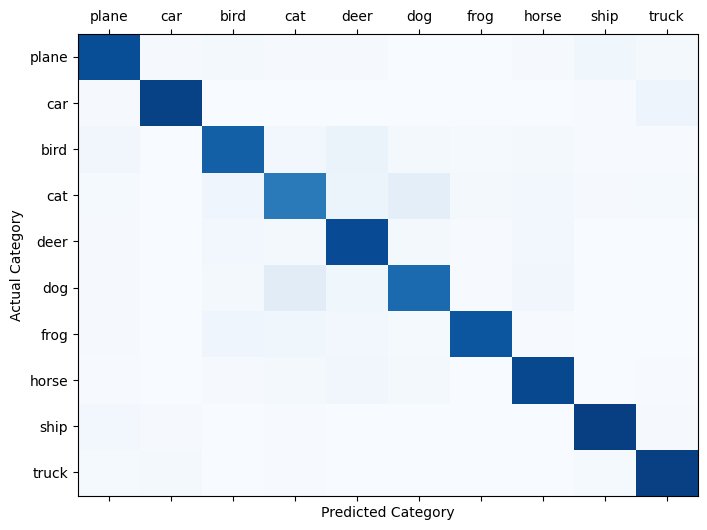

In [11]:
# load model, calculate accuracy and confusion matrix
model = CifarCNN().to(device)
state = torch.load('./checkpoints/cifar_cnn_ckpt.pth', map_location=device)
model.load_state_dict(state['net'])
# note: `map_location` is necessary if you trained on the GPU and want to run inference on the CPU

test_accuracy, confusion_matrix = calculate_accuracy(model, testloader, device)
print("test accuracy: {:.3f}%".format(test_accuracy))

# plot confusion matrix
fig, ax = plt.subplots(1,1,figsize=(8,6))
ax.matshow(confusion_matrix, aspect='auto', vmin=0, vmax=1000, cmap=plt.get_cmap('Blues'))
plt.ylabel('Actual Category')
plt.yticks(range(10), classes)
plt.xlabel('Predicted Category')
plt.xticks(range(10), classes)
plt.show()

## <img src="https://img.icons8.com/dusk/64/000000/doughnut-chart.png" style="height:50px;display:inline"> Visualizing CNN Filters
---

## <img src="https://img.icons8.com/color/96/000000/xray.png" style="height:50px;display:inline"> Visualizing Layer Output
---
* We can see which neurons are active for every input image.
* This way we can a better understanding of what the network sees during forward pass, which probably affects the final prediction.
* Let's see an example by <a href="https://github.com/sar-gupta/convisualize_nb/blob/master/cnn-visualize.ipynb">Sarthak Gupta </a>.

In [12]:
# helper functions
def to_grayscale(image):
    """
    input is (d,w,h)
    converts 3D image tensor to grayscale images corresponding to each channel
    """
    image = torch.sum(image, dim=0)
    image = torch.div(image, image.shape[0])
    return image

def normalize(image, device=torch.device("cpu")):
    normalize = transforms.Normalize(
    mean=[0.485, 0.456, 0.406],
    std=[0.229, 0.224, 0.225]
    )
    preprocess = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    normalize
    ])
    image = preprocess(image).unsqueeze(0).to(device)
    return image


def predict(image, model, labels=None):
    _, index = model(image).data[0].max(0)
    if labels is not None:
        return str(index.item()), labels[str(index.item())][1]
    else:
        return str(index.item()) 
    
def deprocess(image, device=torch.device("cpu")):
    return image * torch.tensor([0.229, 0.224, 0.225]).to(device) + torch.tensor([0.485, 0.456, 0.406]).to(device)

def load_image(path):
    image = Image.open(path)
    plt.imshow(image)
    plt.title("Image loaded successfully")
    return image

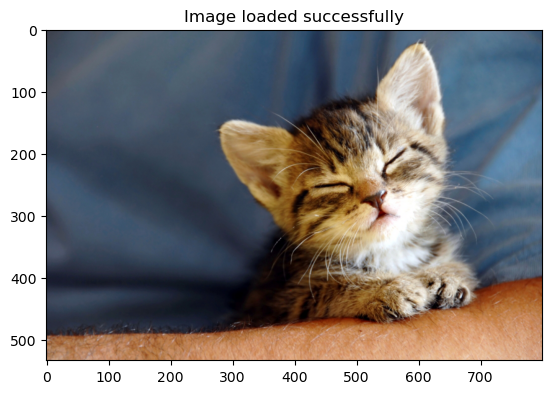

In [13]:
# load sample image
kitten_img = load_image("./assets/kitten.jpg")

### <img src="https://img.icons8.com/nolan/64/download-from-cloud.png" style="height:50px;display:inline"> Torchvision Pre-Trained Models
---
* `torchvision.models` 子包包含用于解决不同任务的模型定义，包括：图像分类、像素级语义分割、对象检测、实例分割、人物关键点检测、视频分类和光流。
* 您可以在此处查看所有可用内容 - <a href="https://pytorch.org/vision/stable/models.html">模型和预训练权重</a>。
* 在代码中，您可以使用 <a href="https://pytorch.org/vision/stable/models.html#model-registration-mechanism">`torchvision.models.list_models`</a> 查看所有可用模型的列表。 

#### Output of Each Layer
---

In [ ]:
def layer_outputs(image, model):
    modulelist = list(model.features.modules())
    outputs = []
    names = []
    for index, layer in enumerate(modulelist[1:]):
        image = layer(image)
        outputs.append(image)
        names.append(str(index)+str(layer))
        
    output_im = []
    for i in outputs:
        i = i.squeeze(0)
        temp = to_grayscale(i)  # take the mean
        output_im.append(temp.data.cpu().numpy())
        
    fig = plt.figure(figsize=(10, 20))

    for i in range(len(output_im)):
        a = fig.add_subplot(8, 4, i+1)
        plt.imshow(output_im[i])
        a.set_axis_off()
        a.set_title(names[i].partition('(')[0], fontsize=10)
    plt.tight_layout()
#     plt.savefig('layer_outputs.jpg', bbox_inches='tight')

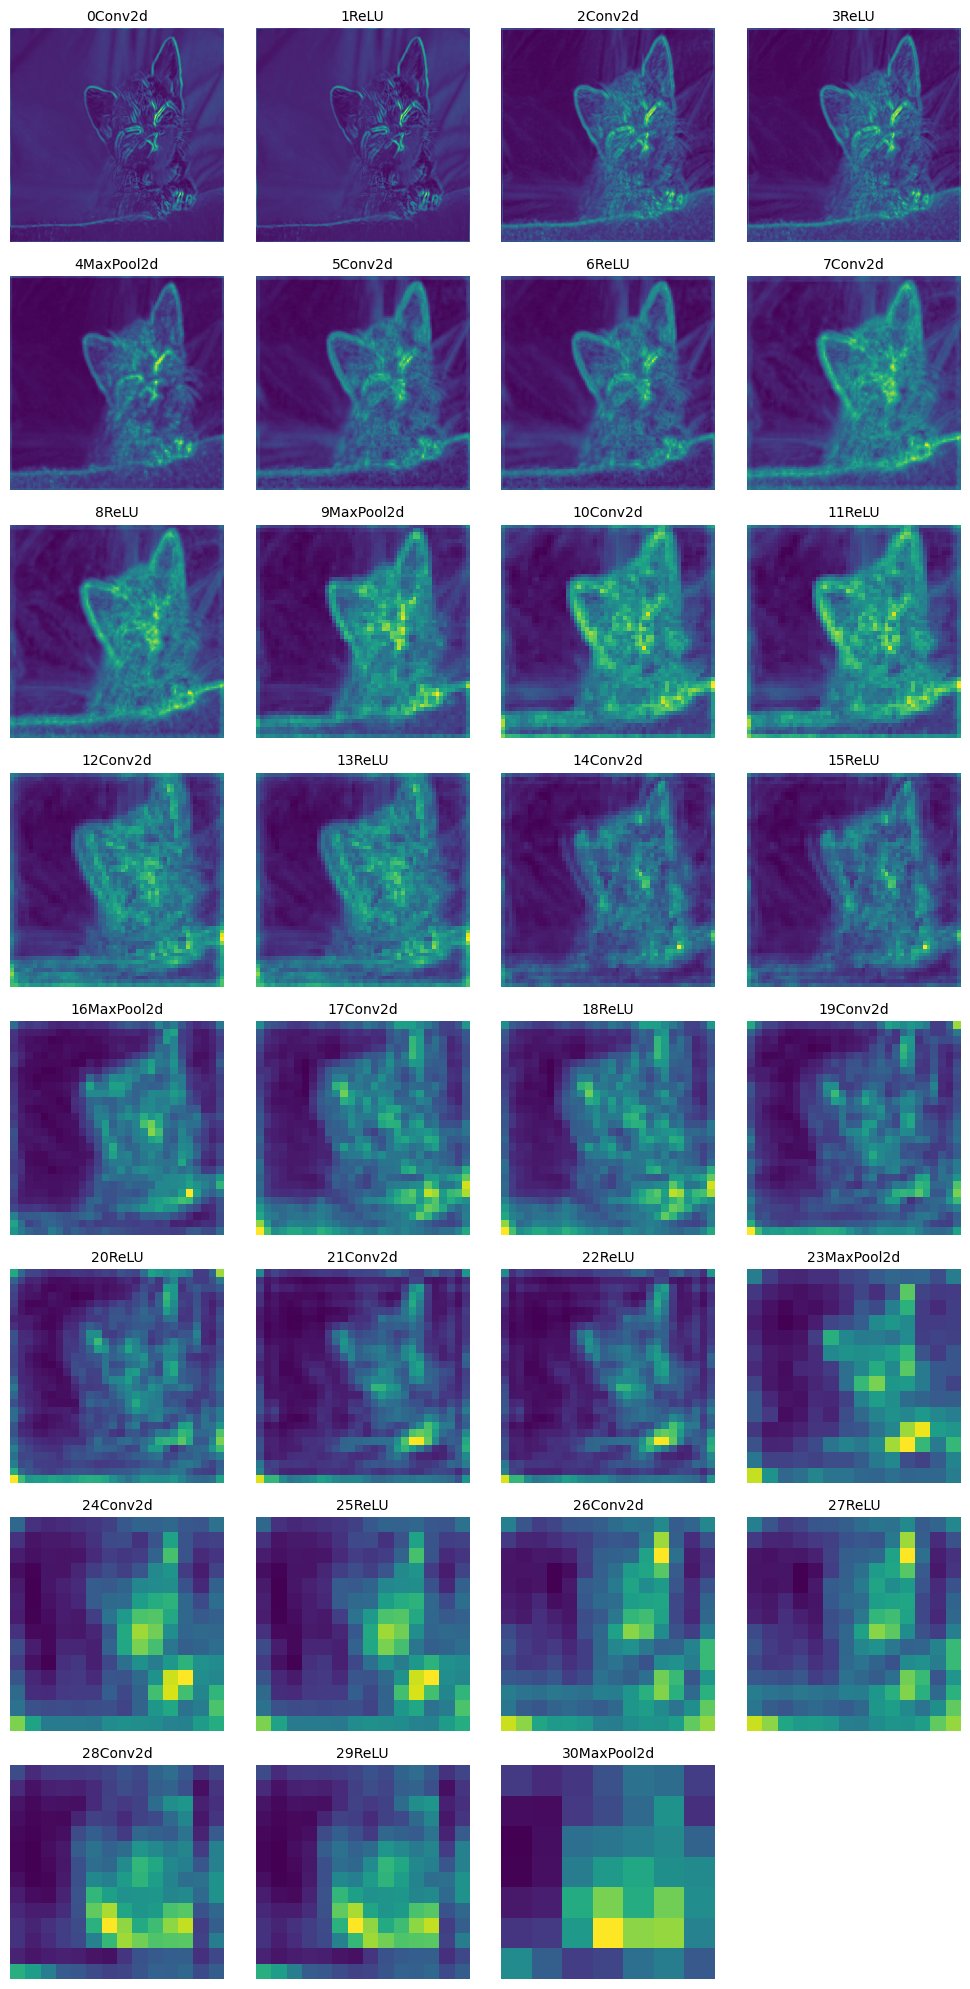

In [ ]:
layer_outputs(prep_img, model)

越往后的层提取的特征越抽象，越不具体。网络试图捕捉的是更高层次的语义信息，而不是具体的像素级别的信息。

#### Output of Each Filter for a Certain Layer
---

In [ ]:
def filter_outputs(image, model, layer_to_visualize):
    modulelist = list(model.features.modules())
    if layer_to_visualize < 0:
        layer_to_visualize += 31
    output = None
    name = None
    for count, layer in enumerate(modulelist[1:]):
        image = layer(image)
        if count == layer_to_visualize: 
            output = image
            name = str(layer)
    
    filters = []
    output = output.data.squeeze().cpu().numpy()
    for i in range(output.shape[0]):
        filters.append(output[i,:,:])
        
    fig = plt.figure(figsize=(10, 10))

    for i in range(int(np.sqrt(len(filters))) * int(np.sqrt(len(filters)))):
        ax = fig.add_subplot(int(np.sqrt(len(filters))), int(np.sqrt(len(filters))), i+1)
        imgplot = ax.imshow(filters[i])
        ax.set_axis_off()
    plt.tight_layout()

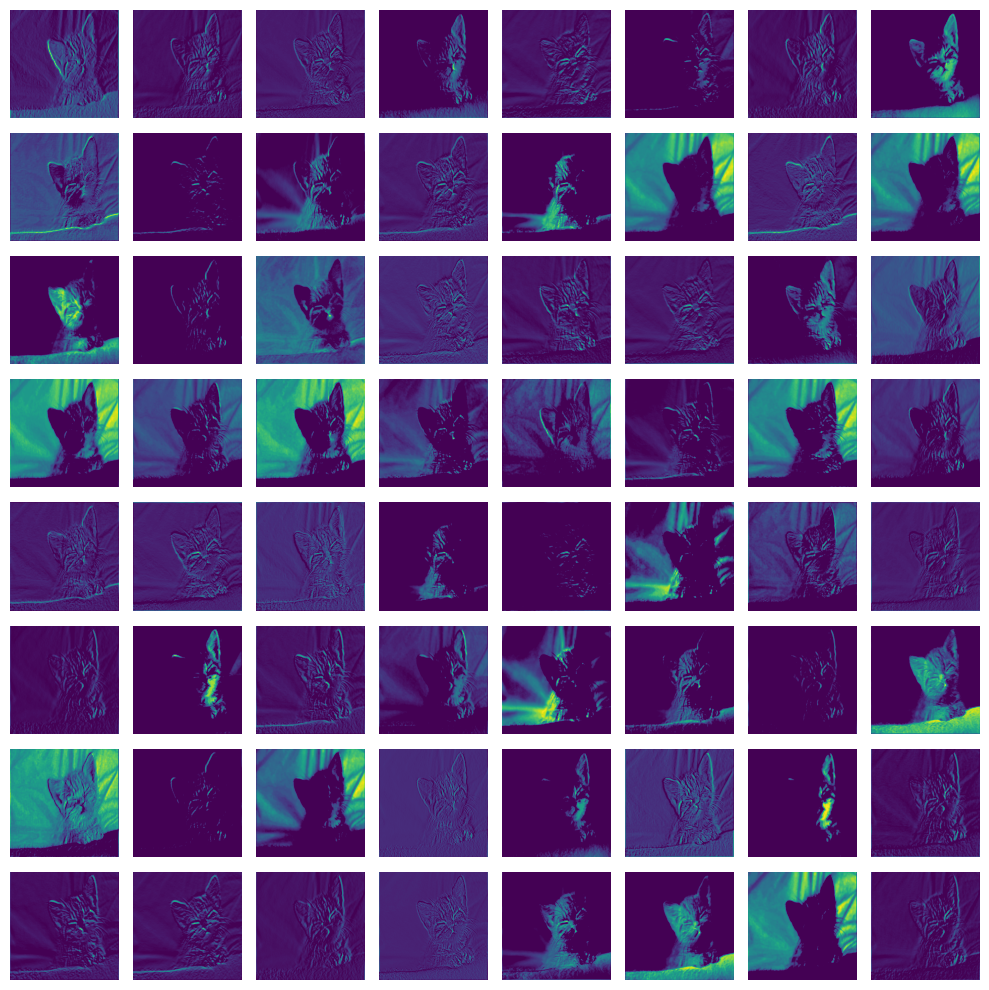

In [ ]:
filter_outputs(prep_img, model, 0)

#### CNN Explainer Demo
---
<a href="https://poloclub.github.io/cnn-explainer/">Open Demo</a>

<center><img src="./assets/convlayer_demo.gif" style="height:200px"></center>

<a href="https://arxiv.org/pdf/1311.2901">ZFNet: Visualizing and Understanding Convolutional Networks</a>

## <img src="https://img.icons8.com/cute-clipart/64/000000/easter-egg.png" style="height:50px;display:inline"> Are CNNs the Holy Grail? The Problem with CNNs
---
#### 深度神经网络对对抗性攻击很敏感。
---
* 例如：考虑下面的图像，左侧是一头猪的图像，该图像被最先进的卷积神经网络正确分类。
* 在对图像进行轻微扰动后（每个像素都在 [0, 1] 范围内，最多改变 0.005），网络现在以高置信度返回“客机”类别。
    
<center><img src="./assets/tut_conv_pig.png" style="height:200px"></center>

<a href="http://gradientscience.org/intro_adversarial/">Image Source</a>

#### 识别算法对新环境的泛化能力较差
---
<center><img src="./assets/tut_conv_cow.PNG" style="height:500px"></center>

<a href="https://arxiv.org/pdf/1807.04975.pdf">Recognition in Terra Incognita (Beery et al., 2018)</a>

泛化能力指的是模型在训练数据以外的未见过的数据上的表现能力。在这张图片中，通过展示算法在不同环境下（例如牧场、水边、沙滩）对同一对象（牛）的识别结果，可以看到算法在不同环境下的识别准确性和置信度。

- 环境A（牧场）：算法能够非常高置信度地识别出牛以及其他相关标签。
- 环境B（水边）：算法的置信度依然很高，但识别出了更多与水相关的标签。
- 环境C（沙滩）：算法的识别置信度略有降低，且出现了更多与沙滩环境相关的标签。

通过这些结果可以看出，尽管识别算法在新环境中依然能识别出主要对象（牛），但会受到环境变化的影响，识别出其他与环境相关的标签。

#### 神经网络往往会表现出不良偏见
---
<center><img src="./assets/tut_conv_fairness.PNG" style="height:500px"></center>

* 模型学习这些偏见的原因尚不清楚。
* 一个假设是，神经网络学习到的偏见可能源自训练数据的不平衡。比如，某些运动员的图片在训练数据集中出现频率较高，导致模型对这些图片的预测结果倾向于某些特定的类别。
图片的背景、肤色、运动服等因素可能导致模型产生误导性的预测。

<a href="https://arxiv.org/abs/1711.11443">ConvNets and ImageNet Beyond Accuracy: Understanding Mistakes and Uncovering Biases (Stock and Cisse, 2018)</a>

## <img src="https://img.icons8.com/clouds/100/000000/lightning-bolt.png" style="height:50px;display:inline"> CNNs Applications in Computer Vision
---
See 1000+ computer vision tasks with benchmarks and papers on <a href="https://paperswithcode.com/area/computer-vision">PapersWithCode.com</a>.

* **Object Detection**

<center><img src="./assets/tut_conv_obj_det.PNG" style="height:200px"></center>

<a href="https://medium.com/better-programming/real-time-object-detection-on-gpus-in-10-minutes-6e8c9b857bb3"> Source</a>

* **Semantic Segmentation**

<center><img src="./assets/tut_conv_segnet.png" style="height:200px"></center>


<a href="https://missinglink.ai/guides/computer-vision/image-segmentation-deep-learning-methods-applications/">Source</a>

* **Super Resolution**

<center><img src="./assets/tut_conv_superres.PNG" style="height:300px"></center>


<a href="https://arxiv.org/pdf/1609.04802.pdf">Source</a>

* **Style Transfer**

<center><img src="./assets/tut_conv_style_trans.jpeg" style="height:300px"></center>


<a href="https://towardsdatascience.com/light-on-math-machine-learning-intuitive-guide-to-neural-style-transfer-ef88e46697ee">Source</a>

* **Image Editing**

<center><img src="./assets/tut_conv_image_edit.jpg" style="height:300px"></center>


<a href="http://people.csail.mit.edu/junyanz/projects/gvm/">Source</a>

* **Image Generation**

StyleGAN (V1-3) - <a href="https://thispersondoesnotexist.com/">thispersondoesnotexist.com</a>

* **Multi-Signals**
Synthesizing Obama: Learning Lip Sync from Audio


<center><img src="./assets/tut_conv_obama.png" style="height:300px"></center>


<a href="http://grail.cs.washington.edu/projects/AudioToObama/">Source</a>

## <img src="https://img.icons8.com/dusk/64/000000/prize.png" style="height:50px;display:inline"> Credits
---
* Icons made by <a href="https://www.flaticon.com/authors/becris" title="Becris">Becris</a> from <a href="https://www.flaticon.com/" title="Flaticon">www.flaticon.com</a>
* Icons from <a href="https://icons8.com/">Icons8.com</a> - https://icons8.com
* Some slides from CS131 and CS231n (Stanford)
* Deep Learning with Pytorch on CIFAR10 Dataset - <a href="https://www.stefanfiott.com/machine-learning/cifar-10-classifier-using-cnn-in-pytorch/">Zhenye's Blog</a>
* CIFAR-10 Classifier Using CNN in PyTorch - <a href="https://www.stefanfiott.com/machine-learning/cifar-10-classifier-using-cnn-in-pytorch/">Stefan Fiott</a>
* <a href="https://taldatech.github.io">Tal Daniel</a>